### This section is ONLY about cleaning, selecting features & Model Training.

In [ ]:
import pandas as pd

In [2]:

df = pd.read_csv('../data/winequality-all.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [ ]:
#Median imputation
df['free sulfur dioxide'].fillna(df['free sulfur dioxide'].median(), inplace=True)
df['total sulfur dioxide'].fillna(df['total sulfur dioxide'].median(), inplace=True)

In [2]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 1177


In [3]:
# Remove duplicates
df.drop_duplicates(inplace=True)
print("Dataset shape after removing duplicates:", df.shape)

Dataset shape after removing duplicates: (5320, 13)


In [4]:
# Save cleaned dataset to a new file
df.to_csv('../data/winequality-cleaned.csv', index=False)
print("Cleaned dataset saved as 'winequality-cleaned.csv'")

Cleaned dataset saved as 'winequality-cleaned.csv'


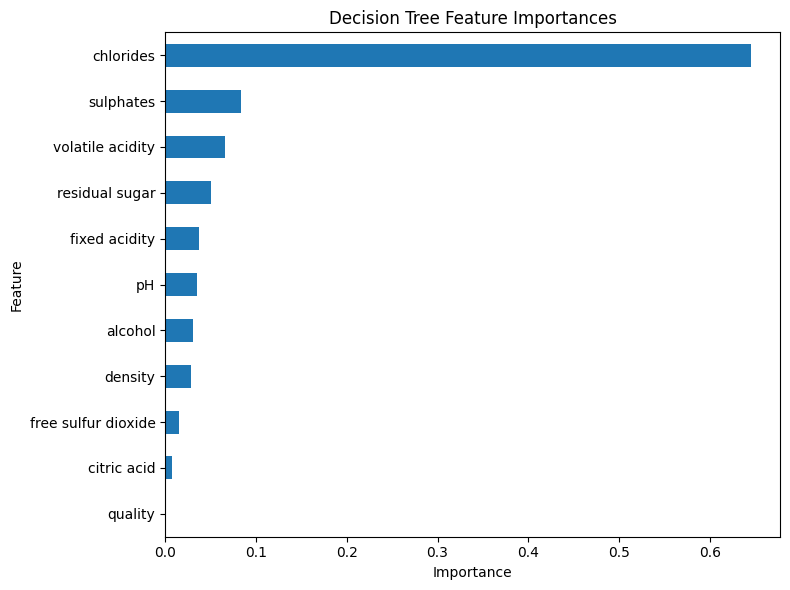

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Encoding target variable 
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])  

# Droping highly correlated feature
df_filtered = df.drop(columns=['total sulfur dioxide'])  

X = df_filtered.drop(columns=['type'])
y = df_filtered['type']

# Normalizing features 
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# feature importances
feature_importances = pd.Series(tree.feature_importances_, index=X.columns)

plt.figure(figsize=(8, 6))
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [6]:
# Selecting features with importance
selected_features = feature_importances[feature_importances > 0.03].index.tolist()
X_selected = X[selected_features]
df_clean = df[selected_features + ['type']]
print("Selected Features:", selected_features)

Selected Features: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'pH', 'sulphates', 'alcohol']


## Distribution of the target variable

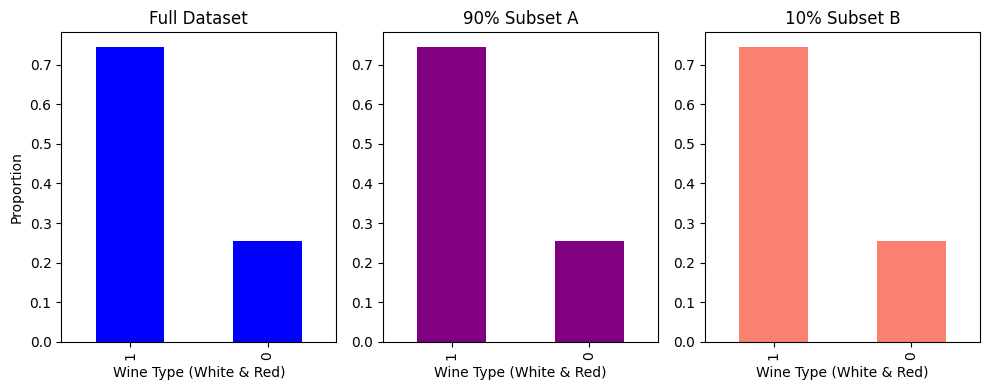

In [7]:
# Shuffling and splitting
X_A, X_B, y_A, y_B = train_test_split(
    X_selected, y, test_size=0.10, random_state=42, stratify=y
)

def plot_distribution(y_all, y_A, y_B):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    y_all.value_counts(normalize=True).plot(kind='bar', color='blue')
    plt.title("Full Dataset")
    plt.xlabel("Wine Type (White & Red)")
    plt.ylabel("Proportion")

    plt.subplot(1, 3, 2)
    y_A.value_counts(normalize=True).plot(kind='bar', color='purple')
    plt.title("90% Subset A")
    plt.xlabel("Wine Type (White & Red)")

    plt.subplot(1, 3, 3)
    y_B.value_counts(normalize=True).plot(kind='bar', color='salmon')
    plt.title("10% Subset B")
    plt.xlabel("Wine Type (White & Red)")

    plt.tight_layout()
    plt.show()

plot_distribution(y, y_A, y_B)

## Decision Tree model Training

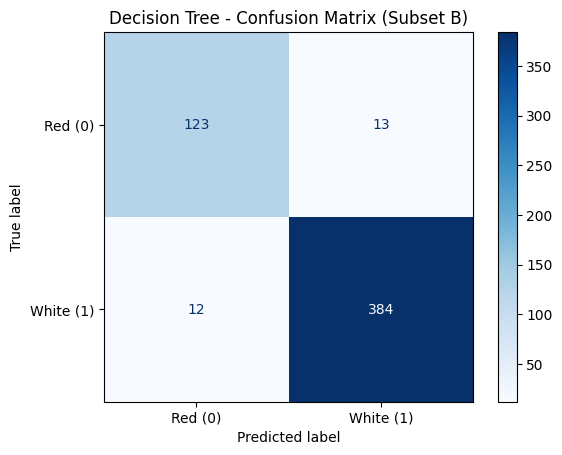

Confusion Matrix:
 [[123  13]
 [ 12 384]]
Classification Report:

              precision    recall  f1-score   support

         Red       0.91      0.90      0.91       136
       White       0.97      0.97      0.97       396

    accuracy                           0.95       532
   macro avg       0.94      0.94      0.94       532
weighted avg       0.95      0.95      0.95       532

              precision    recall  f1-score   support

         Red       0.94      0.94      0.94      1223
       White       0.98      0.98      0.98      3565

    accuracy                           0.97      4788
   macro avg       0.96      0.96      0.96      4788
weighted avg       0.97      0.97      0.97      4788



In [8]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Training Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt_model.fit(X_A, y_A)

# Predicting
y_pred_dt = dt_model.predict(X_B)
xa_pred_dt = dt_model.predict(X_A)

# Confusion Matrix
cm = confusion_matrix(y_B, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red (0)', 'White (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree - Confusion Matrix (Subset B)")
plt.show()
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_B, y_pred_dt, target_names=['Red', 'White']))
print(classification_report(y_A, xa_pred_dt, target_names=['Red', 'White']))


## Naïve Bayes model

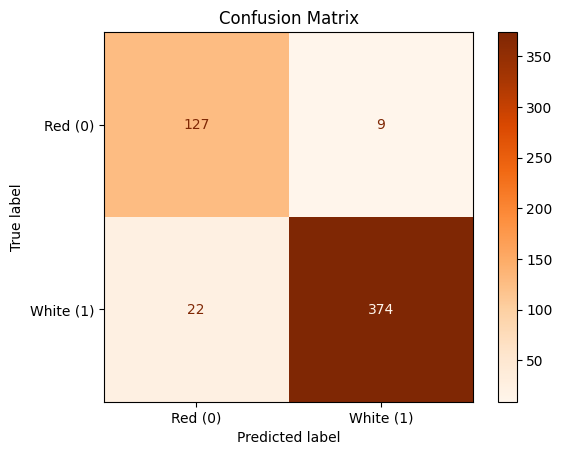

Confusion Matrix:
 [[127   9]
 [ 22 374]]
Classification Report:

              precision    recall  f1-score   support

         Red       0.85      0.93      0.89       136
       White       0.98      0.94      0.96       396

    accuracy                           0.94       532
   macro avg       0.91      0.94      0.93       532
weighted avg       0.94      0.94      0.94       532

              precision    recall  f1-score   support

         Red       0.86      0.92      0.89      1223
       White       0.97      0.95      0.96      3565

    accuracy                           0.94      4788
   macro avg       0.92      0.94      0.93      4788
weighted avg       0.94      0.94      0.94      4788



In [9]:
from sklearn.naive_bayes import GaussianNB

# Training Naïve Bayes 
nb_model = GaussianNB()
nb_model.fit(X_A, y_A)

# Predicting
y_pred_nb = nb_model.predict(X_B)
xa_pred_nb = nb_model.predict(X_A)

# Confusion Matrix
cm_nb = confusion_matrix(y_B, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Red (0)', 'White (1)'])
disp_nb.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()
print("Confusion Matrix:\n", cm_nb)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_B, y_pred_nb, target_names=['Red', 'White']))
print(classification_report(y_A, xa_pred_nb, target_names=['Red', 'White']))


## 10-fold cross validation

In [10]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

X_cv = df_clean[selected_features]
y_cv = df_clean['type']

f1_scorer = make_scorer(f1_score, pos_label=1)

# Decision Tree 
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt_f1_scores = cross_val_score(dt_model, X_cv, y_cv, cv=10, scoring=f1_scorer)
print("Decision Tree - F1 scores:", dt_f1_scores)
print("Decision Tree - Average F1 score:", np.mean(dt_f1_scores))

# Naïve Bayes 
nb_model = GaussianNB()
nb_f1_scores = cross_val_score(nb_model, X_cv, y_cv, cv=10, scoring=f1_scorer)
print("Naïve Bayes - F1 scores:", nb_f1_scores)
print("Naïve Bayes - Average F1 score:", np.mean(nb_f1_scores))

Decision Tree - F1 scores: [0.97461929 0.97969543 0.97567222 0.9744898  0.96782497 0.95286624
 0.97493734 0.96637609 0.97391304 0.96379526]
Decision Tree - Average F1 score: 0.9704189674133075
Naïve Bayes - F1 scores: [0.96277279 0.95989651 0.95424837 0.9731114  0.95968791 0.95663265
 0.95179234 0.95939086 0.96333755 0.95652174]
Naïve Bayes - Average F1 score: 0.9597392099531039


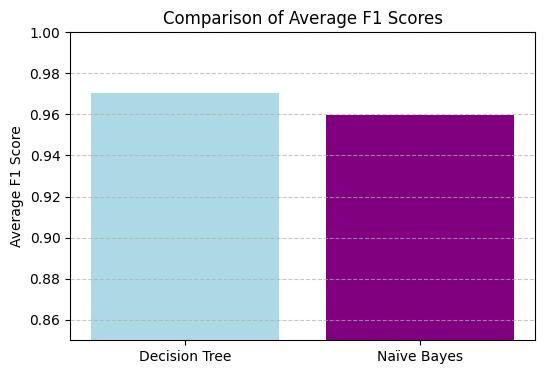

In [11]:
# Average F1-scores
dt_avg = np.mean(dt_f1_scores)
nb_avg = np.mean(nb_f1_scores)

plt.figure(figsize=(6, 4))
plt.bar(['Decision Tree', 'Naïve Bayes'], [dt_avg, nb_avg], color=['lightblue', 'purple'])
plt.ylabel('Average F1 Score')
plt.title('Comparison of Average F1 Scores')
plt.ylim(0.85, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()